#

# Import Modules

In [1]:
import argparse, json, os
import torch

import data as dt
import model as mdl

from torchsummary import summary

from eval import ClassificationEvaluator

# Functions Utils

In [2]:
def _get_transform(config, name):
    tsf_mode = config["data"]["format"]
    tsf_name = config["transforms"]["type"]
    tsf_args = config["transforms"]["args"]
    return getattr(dt, tsf_name)(name, tsf_mode, tsf_args)

def _get_model_att(checkpoint):
    m_name = checkpoint["config"]["model"]["type"]
    sd = checkpoint["state_dict"]
    classes = checkpoint["classes"]
    return m_name, sd, classes

In [3]:
def evaluate(checkpoint):
    config = checkpoint["config"]
    data_config = config["data"]

    tsf = _get_transform(config, "val")

    data_manager = getattr(dt, config["data"]["type"])(config["data"])
    test_loader = data_manager.get_loader("val", tsf)

    m_name, sd, classes = _get_model_att(checkpoint)
    model = getattr(mdl, m_name)(classes, config, state_dict=sd)

    #print(summary(model, (1, 128, 87)))

    model.load_state_dict(checkpoint["state_dict"])

    evaluation = ClassificationEvaluator(test_loader, model)
    result = evaluation.evaluate()

    return result

# Eval

In [4]:
checkpoint = torch.load("saved_cv/ConvNet_0903_101606/checkpoints/model_best.pth", map_location="cpu")
result = evaluate(checkpoint)

**************************************************
10 classes:
['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music']
**************************************************
Number of training data: 6409
Number of validation data: 8415
**************************************************
**************************************************
100%|██████████| 8415/8415 [04:55<00:00, 28.47it/s]


# Interpretation 

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

1896


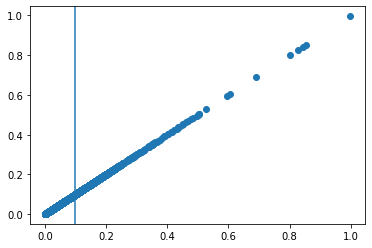

In [6]:
threshold = 0.1
loss_sc = []
for i in result:
    loss = result[i]["loss"]
    loss_sc.append((loss, loss))
plt.scatter(*zip(*loss_sc))
plt.axvline(threshold, 0.0, 1)
print(sum(result[i]["loss"] > threshold for i in range(len(result))))

In [10]:
cmt = torch.zeros(2, 2, dtype=torch.int64)
for key in result:
    anomaly_score = result[key]["loss"]
    if anomaly_score > threshold:
        tl, pl = result[key]["target_label"], 1
    elif result[key]["loss"] < threshold:
        tl, pl = result[key]["target_label"], 0
    cmt[tl, pl] += 1        

<AxesSubplot:>

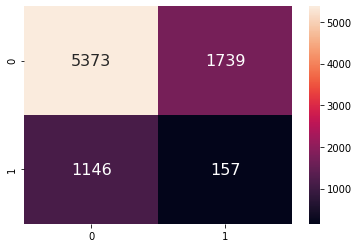

In [26]:
plt.figure()
sns.heatmap(cmt, annot=True, annot_kws={"size": 16}, fmt='g')

In [24]:
8415 - 6409

2006

In [15]:
import pandas as pd

In [16]:
df = pd.read_csv("resources/UrbanSound8K/metadata/autoencoder.csv")

In [18]:
len(df[df["fold"] == 9]), len(df[df["fold"] == 10])

(703, 1303)